In [2]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [3]:
!pip install openpyxl

In [8]:
# Importing required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image
from pymc_marketing import clv
from pymc_marketing.prior import Prior

import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import ParetoNBDFitter

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv('/Users/changyu/Downloads/manifest.csv')
print(data.shape)
data.head()

(4762028, 3)


,customer_id,consume_num,create_time
0,27226,60.0,2019-10-23 15:22:52
1,33376,30.0,2019-10-18 17:27:37
2,28924,30.0,2019-10-15 11:00:34
3,6889,30.0,2019-10-16 13:49:03
4,9720,30.0,2019-10-25 10:56:06


In [3]:
data_summary_rfm = clv.utils.rfm_summary(data, 'customer_id', 'create_time', 'consume_num')
data_summary_rfm = data_summary_rfm[data_summary_rfm['frequency']>0]
data_summary_rfm.head()

,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


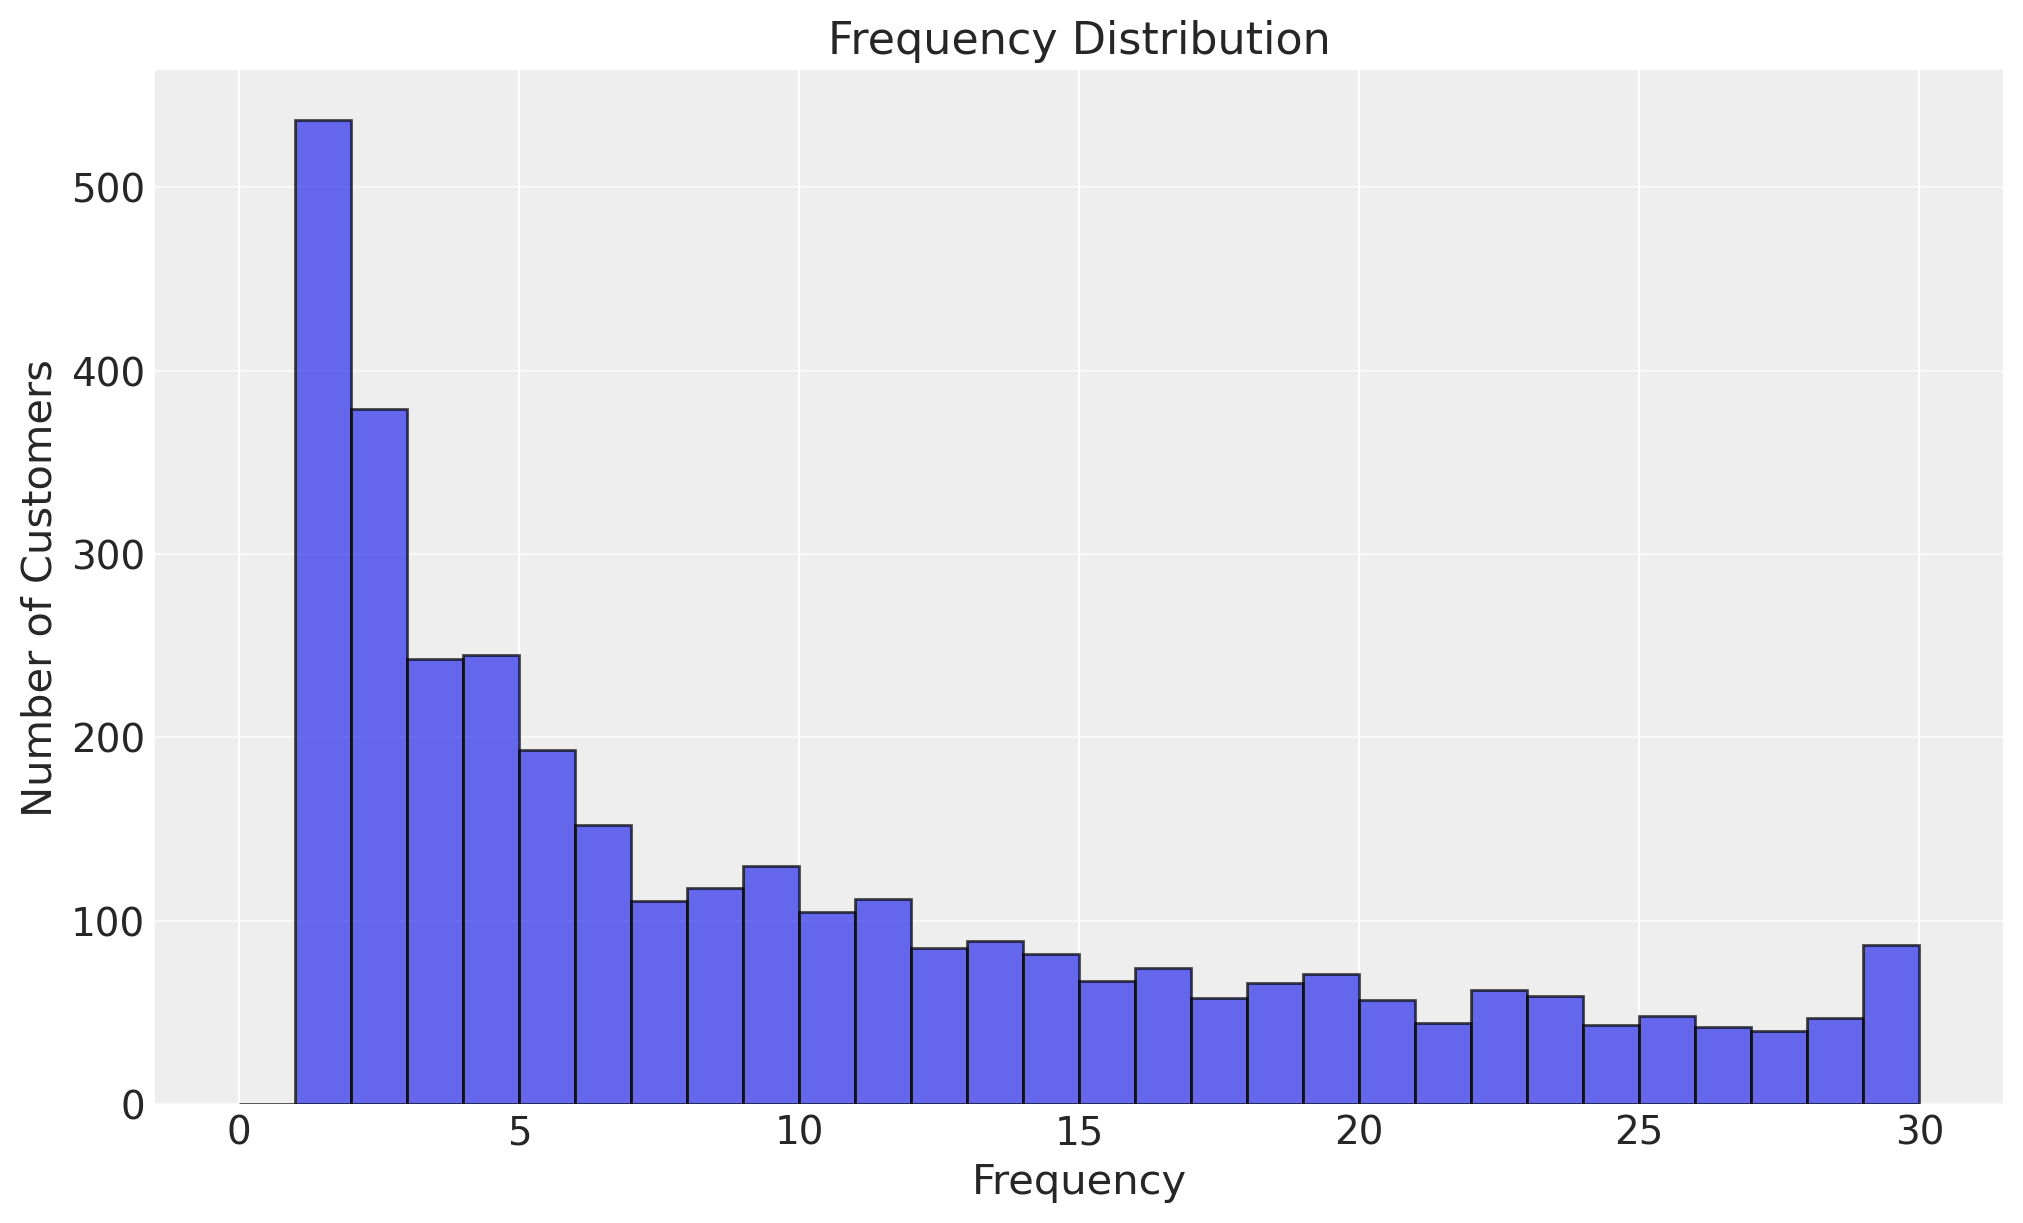

Percentage of customers who purchased only once: 6.71%


In [66]:
# Plotting the frequency distribution of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=30, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")


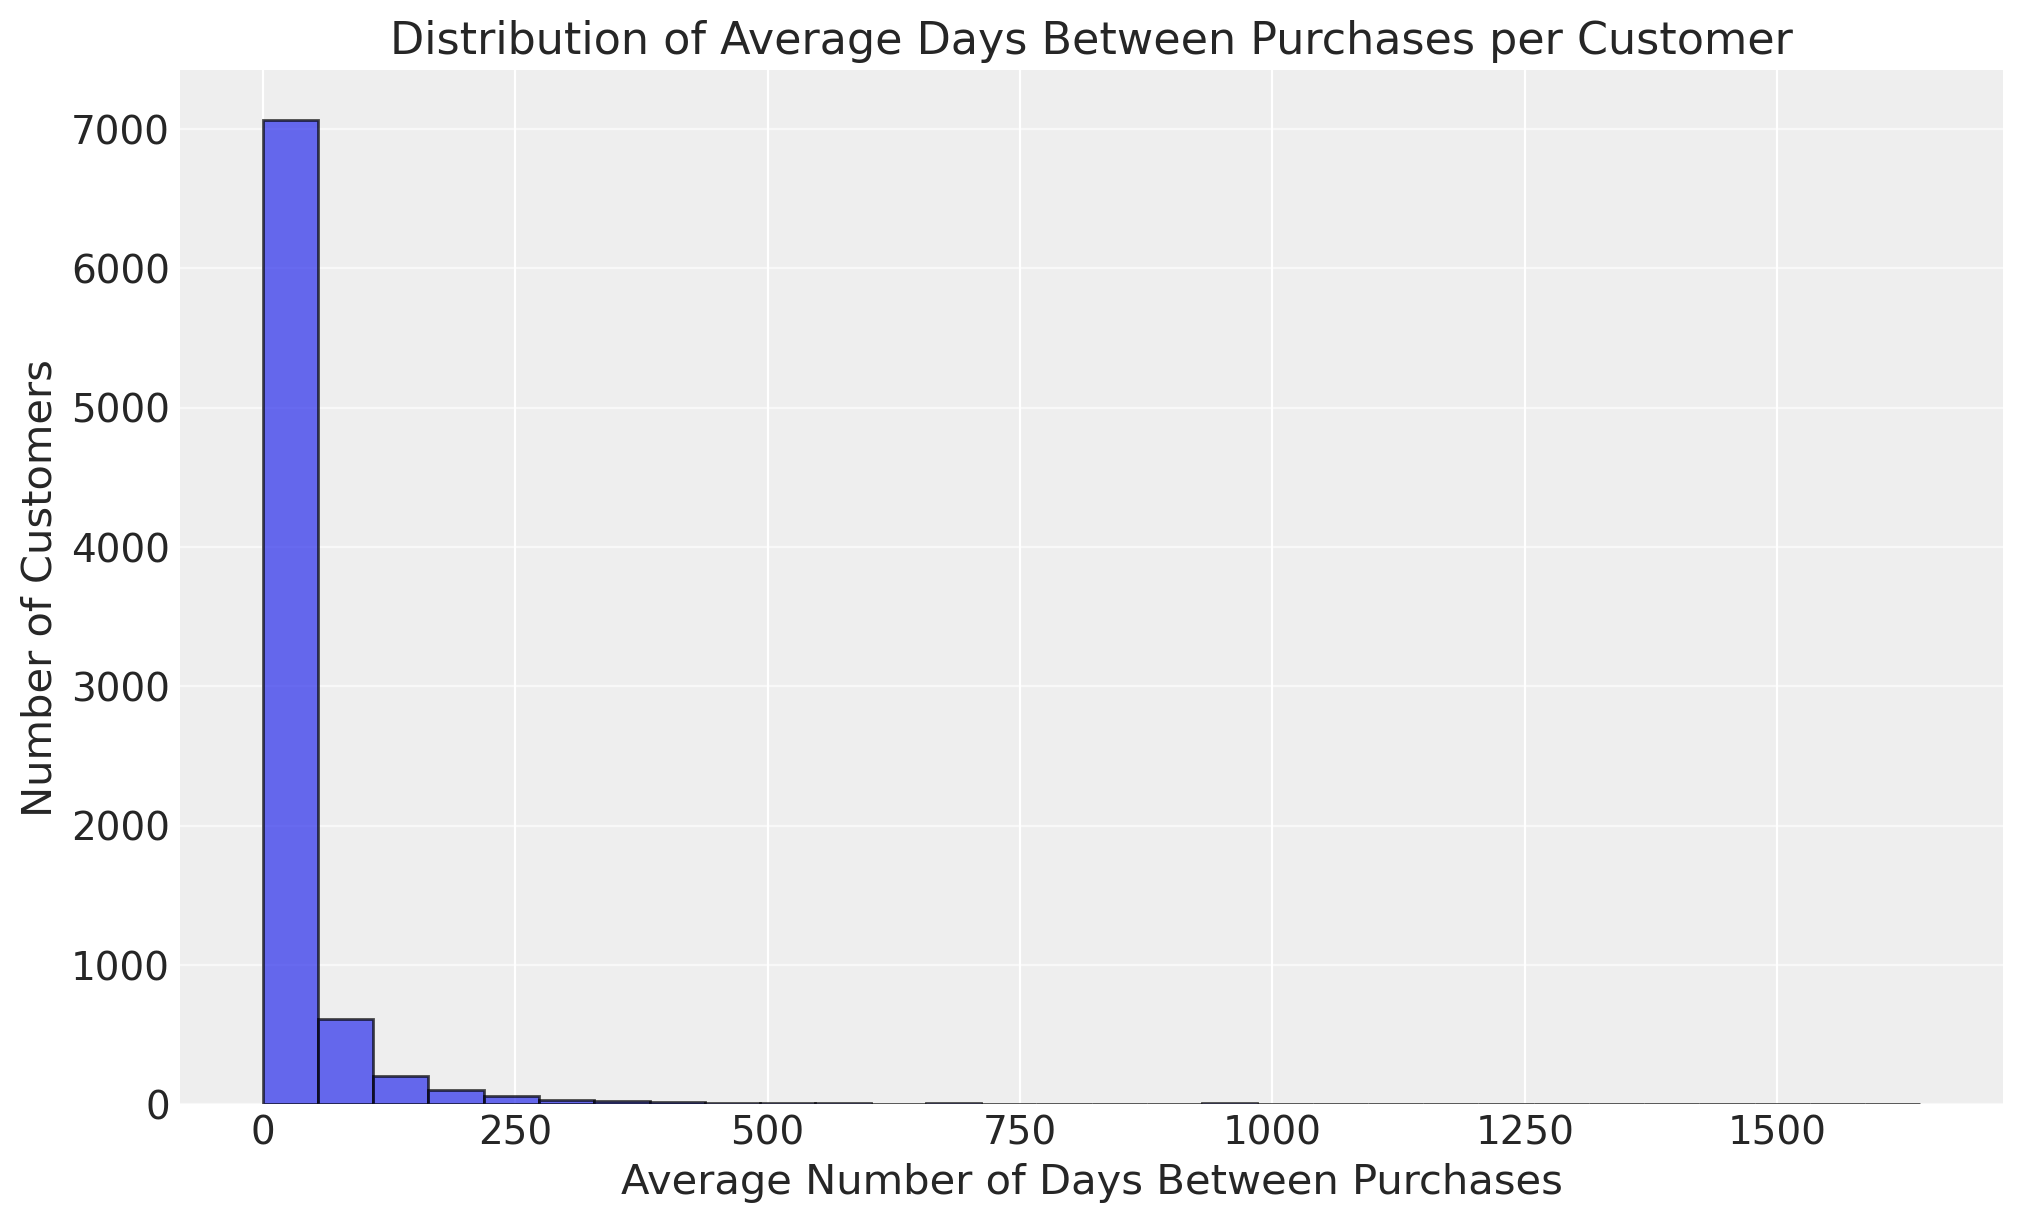

In [67]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
data['create_time'] = pd.to_datetime(data['create_time'])
unique_purchases = data[['customer_id', 'create_time']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['customer_id', 'create_time'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('customer_id')['create_time'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['create_time']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('customer_id')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [6]:
data_summary_rfm.info()
data_summary_rfm.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7998 entries, 0 to 9116
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     7998 non-null   int64  
 1   frequency       7998 non-null   float64
 2   recency         7998 non-null   float64
 3   T               7998 non-null   float64
 4   monetary_value  7998 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 374.9 KB


,customer_id,frequency,recency,T,monetary_value
0,4889,225.0,1890.0,2046.0,61.044444
2,4920,295.0,2039.0,2047.0,63.322034
3,4952,1386.0,1745.0,1746.0,275.937951
5,4967,39.0,1274.0,1276.0,81.410256
6,4979,832.0,2160.0,2162.0,62.391827


In [7]:
freq = data_summary_rfm["frequency"].values
rec = data_summary_rfm["recency"].values
T = data_summary_rfm["T"].values

pnbd_lt = ParetoNBDFitter()
pnbd_lt.fit(freq, rec, T)
pnbd_lt.params_.sort_index()


/Users/changyu/miniconda3/lib/python3.12/site-packages/scipy/special/_logsumexp.py:217: RuntimeWarning: overflow encountered in exp
  exp = b * xp.exp(a - shift) if b is not None else xp.exp(a - shift)
/Users/changyu/miniconda3/lib/python3.12/site-packages/lifetimes/fitters/pareto_nbd_fitter.py:216: RuntimeWarning: invalid value encountered in logaddexp
  A_2 = logaddexp(-(r + x) * log(alpha + T) - s * log(beta + T), log(s) + log_A_0 - log(r_s_x))


alpha      3.548603
beta     889.213919
r          0.565056
s          0.824486
dtype: float64

In [9]:
flat_config = {
    "r": Prior("HalfFlat"),
    "alpha": Prior("HalfFlat"),
    "s": Prior("HalfFlat"),
    "beta": Prior("HalfFlat"),
}

pnbd_pymc = clv.ParetoNBDModel(data=data_summary_rfm, model_config=flat_config)

In [10]:
pnbd_pymc.build_model()  # optional step
pnbd_pymc

Pareto/NBD
            alpha ~ HalfFlat()
             beta ~ HalfFlat()
                r ~ HalfFlat()
                s ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

In [13]:
idata_map = pnbd_pymc.fit(method="map")

Output()

In [14]:
flat_fit = pnbd_pymc.fit_summary()
print(flat_fit)

alpha     5.512
beta     74.226
r         0.644
s         0.126
Name: value, dtype: float64


In [15]:
pnbd_map = clv.ParetoNBDModel(data=data_summary_rfm)
pnbd_map.build_model()  # required for prior predictive checks
pnbd_map

Pareto/NBD
            alpha ~ Weibull(2, 10)
             beta ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
                s ~ Weibull(2, 1)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

Sampling: [alpha, beta, r, recency_frequency, s]
Sampling: [alpha, beta, r, recency_frequency, s]


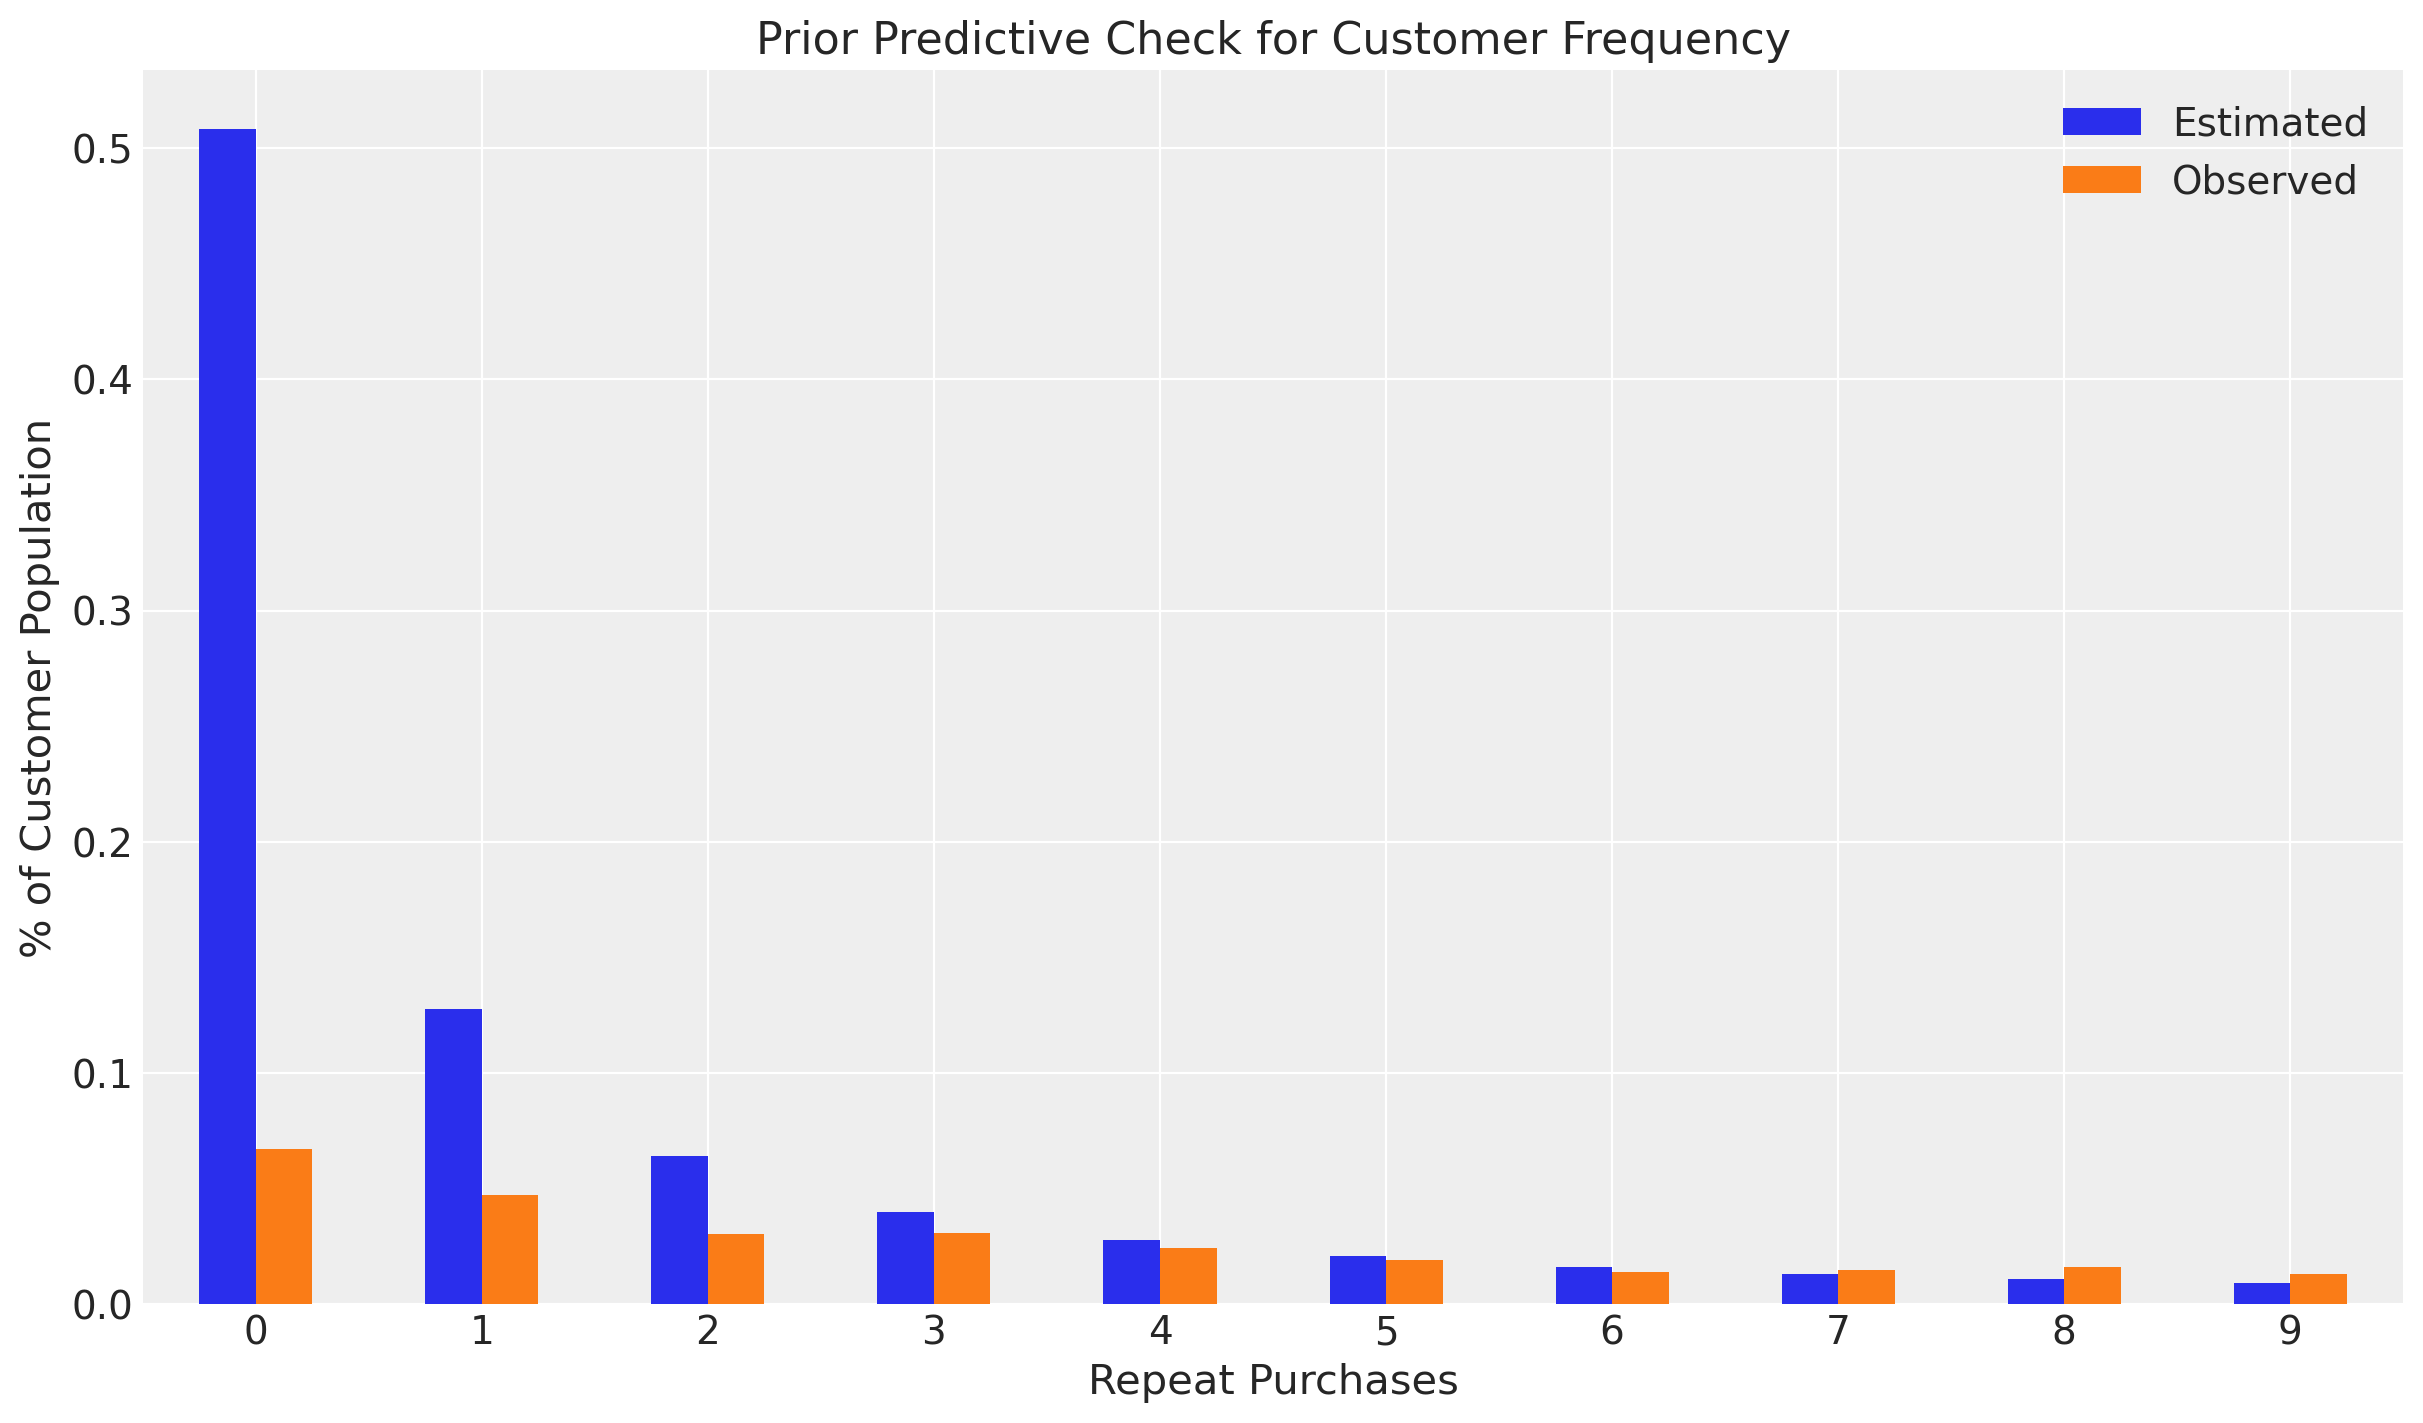

In [16]:
with pnbd_map.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, draws=1)

obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
    0
][0]

# PPC histogram plot
clv.plot_expected_purchases_ppc(pnbd_map, ppc="prior");

Output()

Sampling: [recency_frequency]


Output()

Sampling: [recency_frequency]


Output()

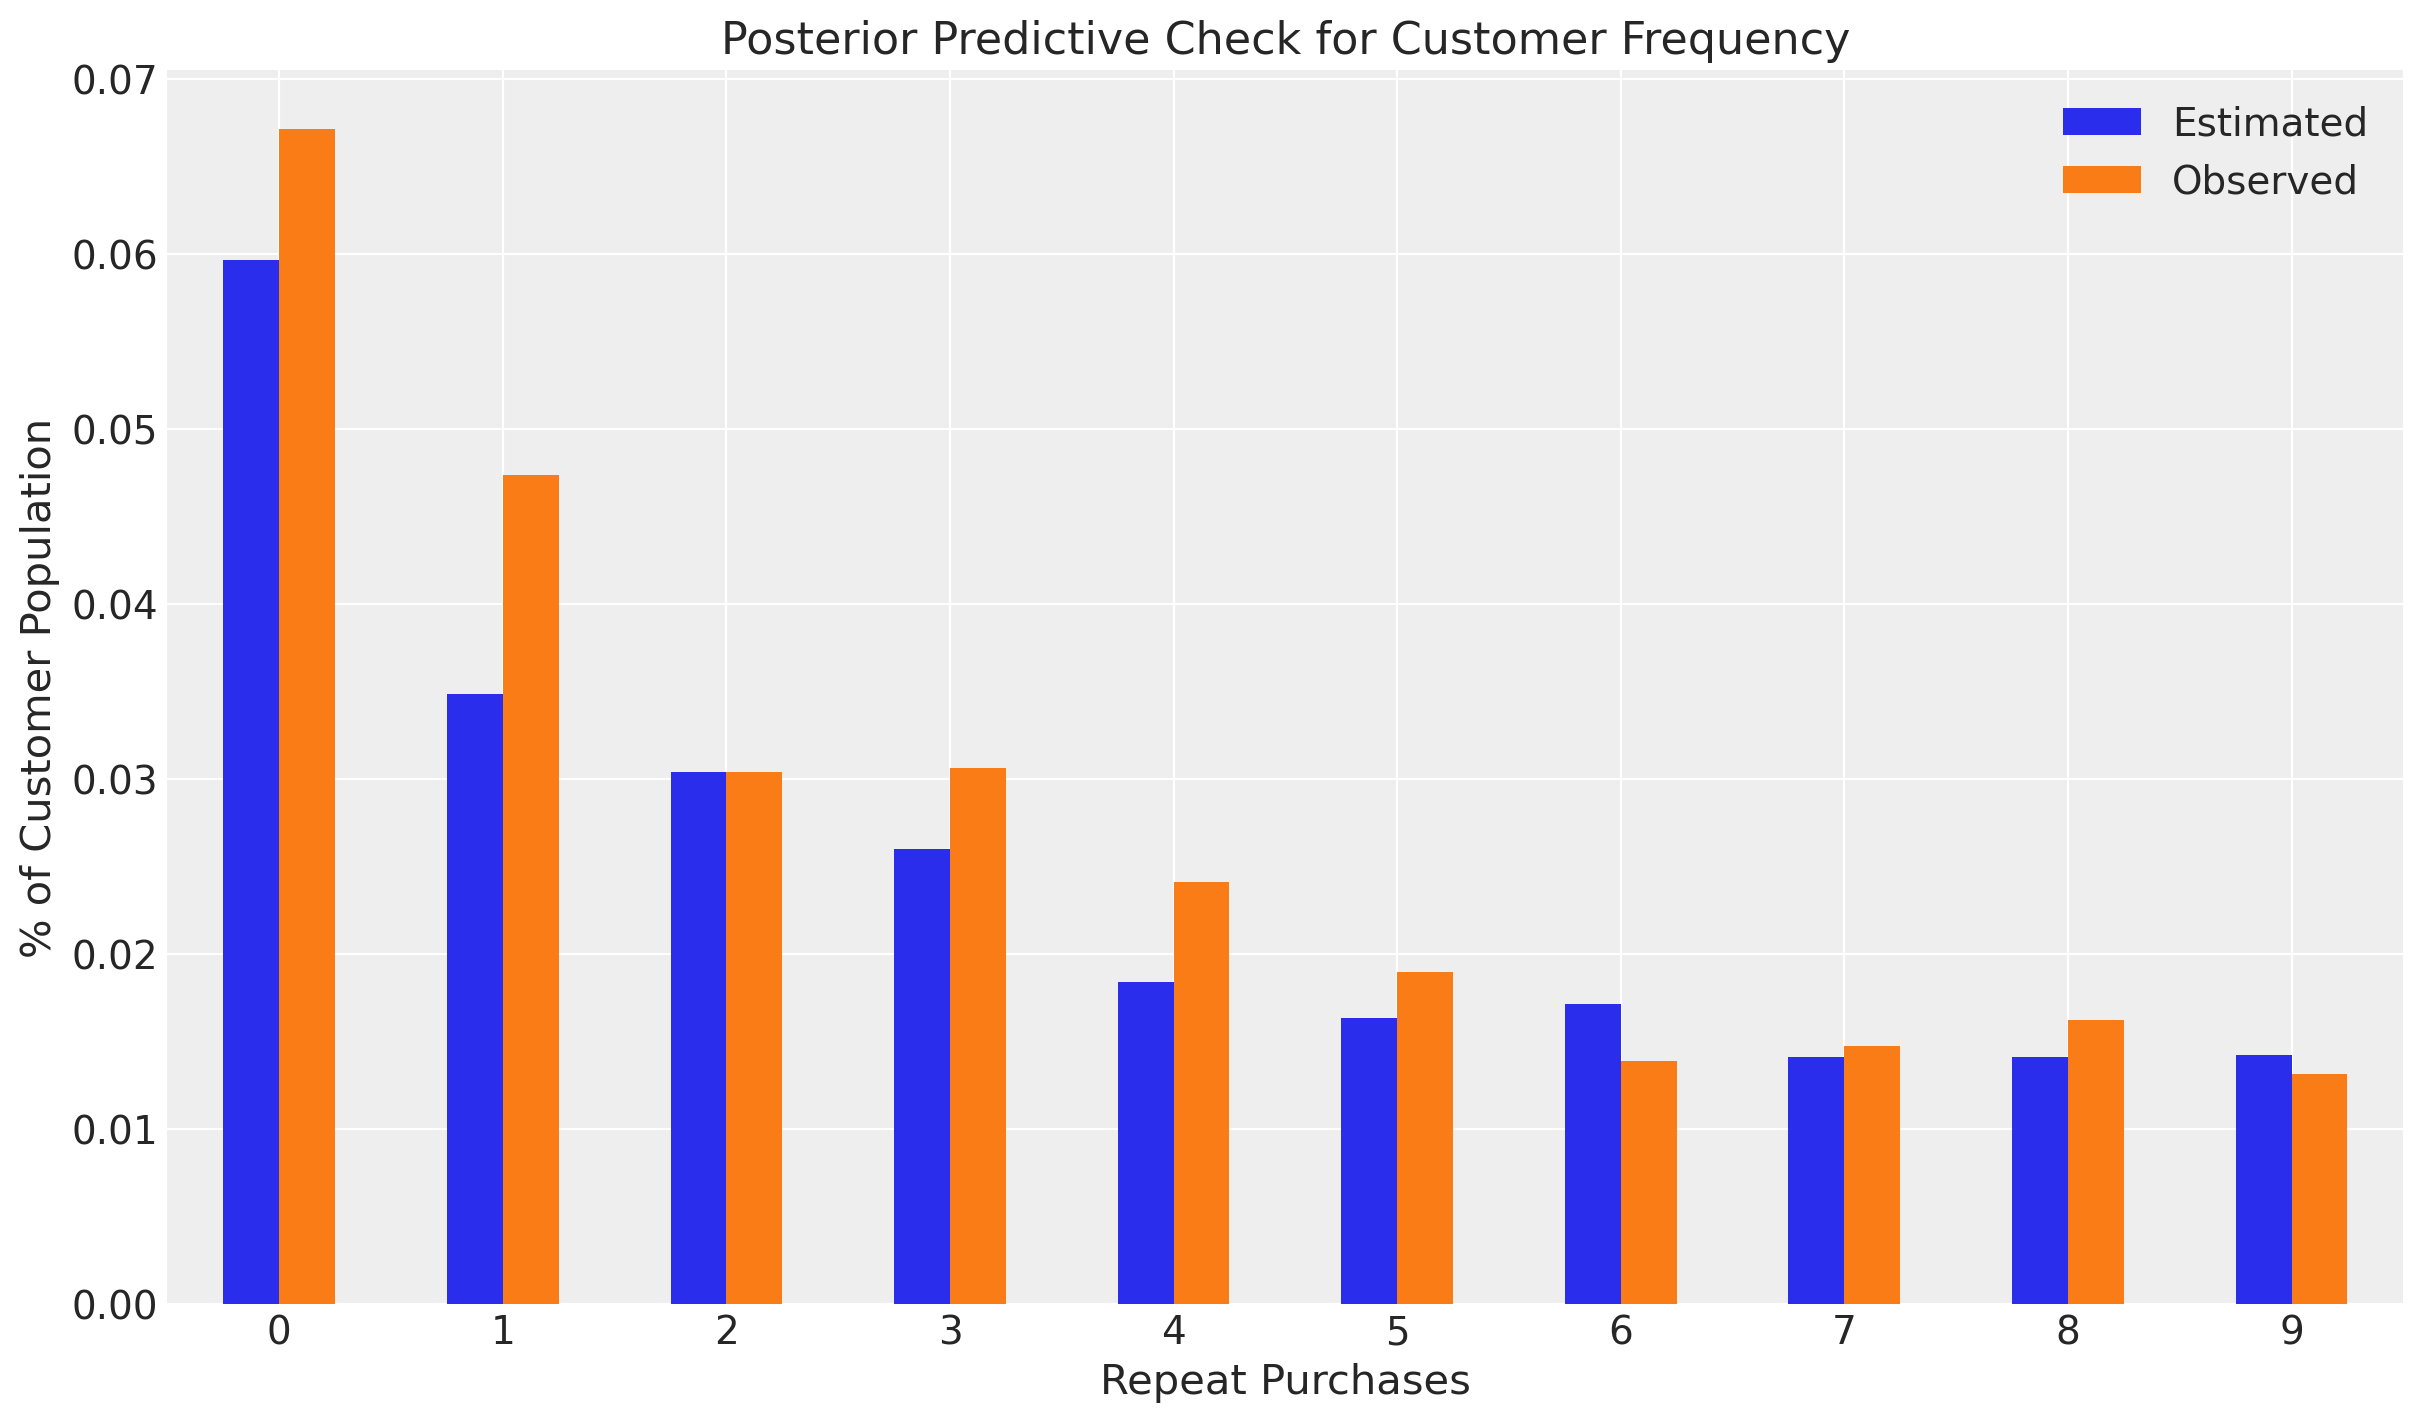

In [17]:
pnbd_map.fit()
map_fit = pnbd_map.fit_summary()  # save for plotting later

obs_freq = pnbd_map.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = pnbd_map.distribution_new_customer_recency_frequency(
    data_summary_rfm,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")

# PPC histogram plot
clv.plot_expected_purchases_ppc(pnbd_map, ppc="posterior");

In [18]:
pnbd_full = clv.ParetoNBDModel(data=data_summary_rfm)
pnbd_full.fit(
    method="demz", draws=3000, tune=2500, idata_kwargs={"log_likelihood": True}
)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

/Users/changyu/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1228: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/changyu/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1228: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/changyu/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1228: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/changyu/miniconda3/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1228: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 4 chains for 2_500 tune and 3_000 draw iterations (10_000 + 12_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

In [20]:
pnbd_full.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.329,0.083,4.184,4.492,0.003,0.002,801.0,1341.0,1.01
beta,106.241,4.448,97.549,114.280,0.162,0.103,759.0,1095.0,1.01
r,0.692,0.010,0.673,0.709,0.000,0.000,936.0,1351.0,1.01
s,0.144,0.004,0.137,0.151,0.000,0.000,748.0,1226.0,1.01


In [21]:
pnbd_full.thin_fit_result(keep_every=2).idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

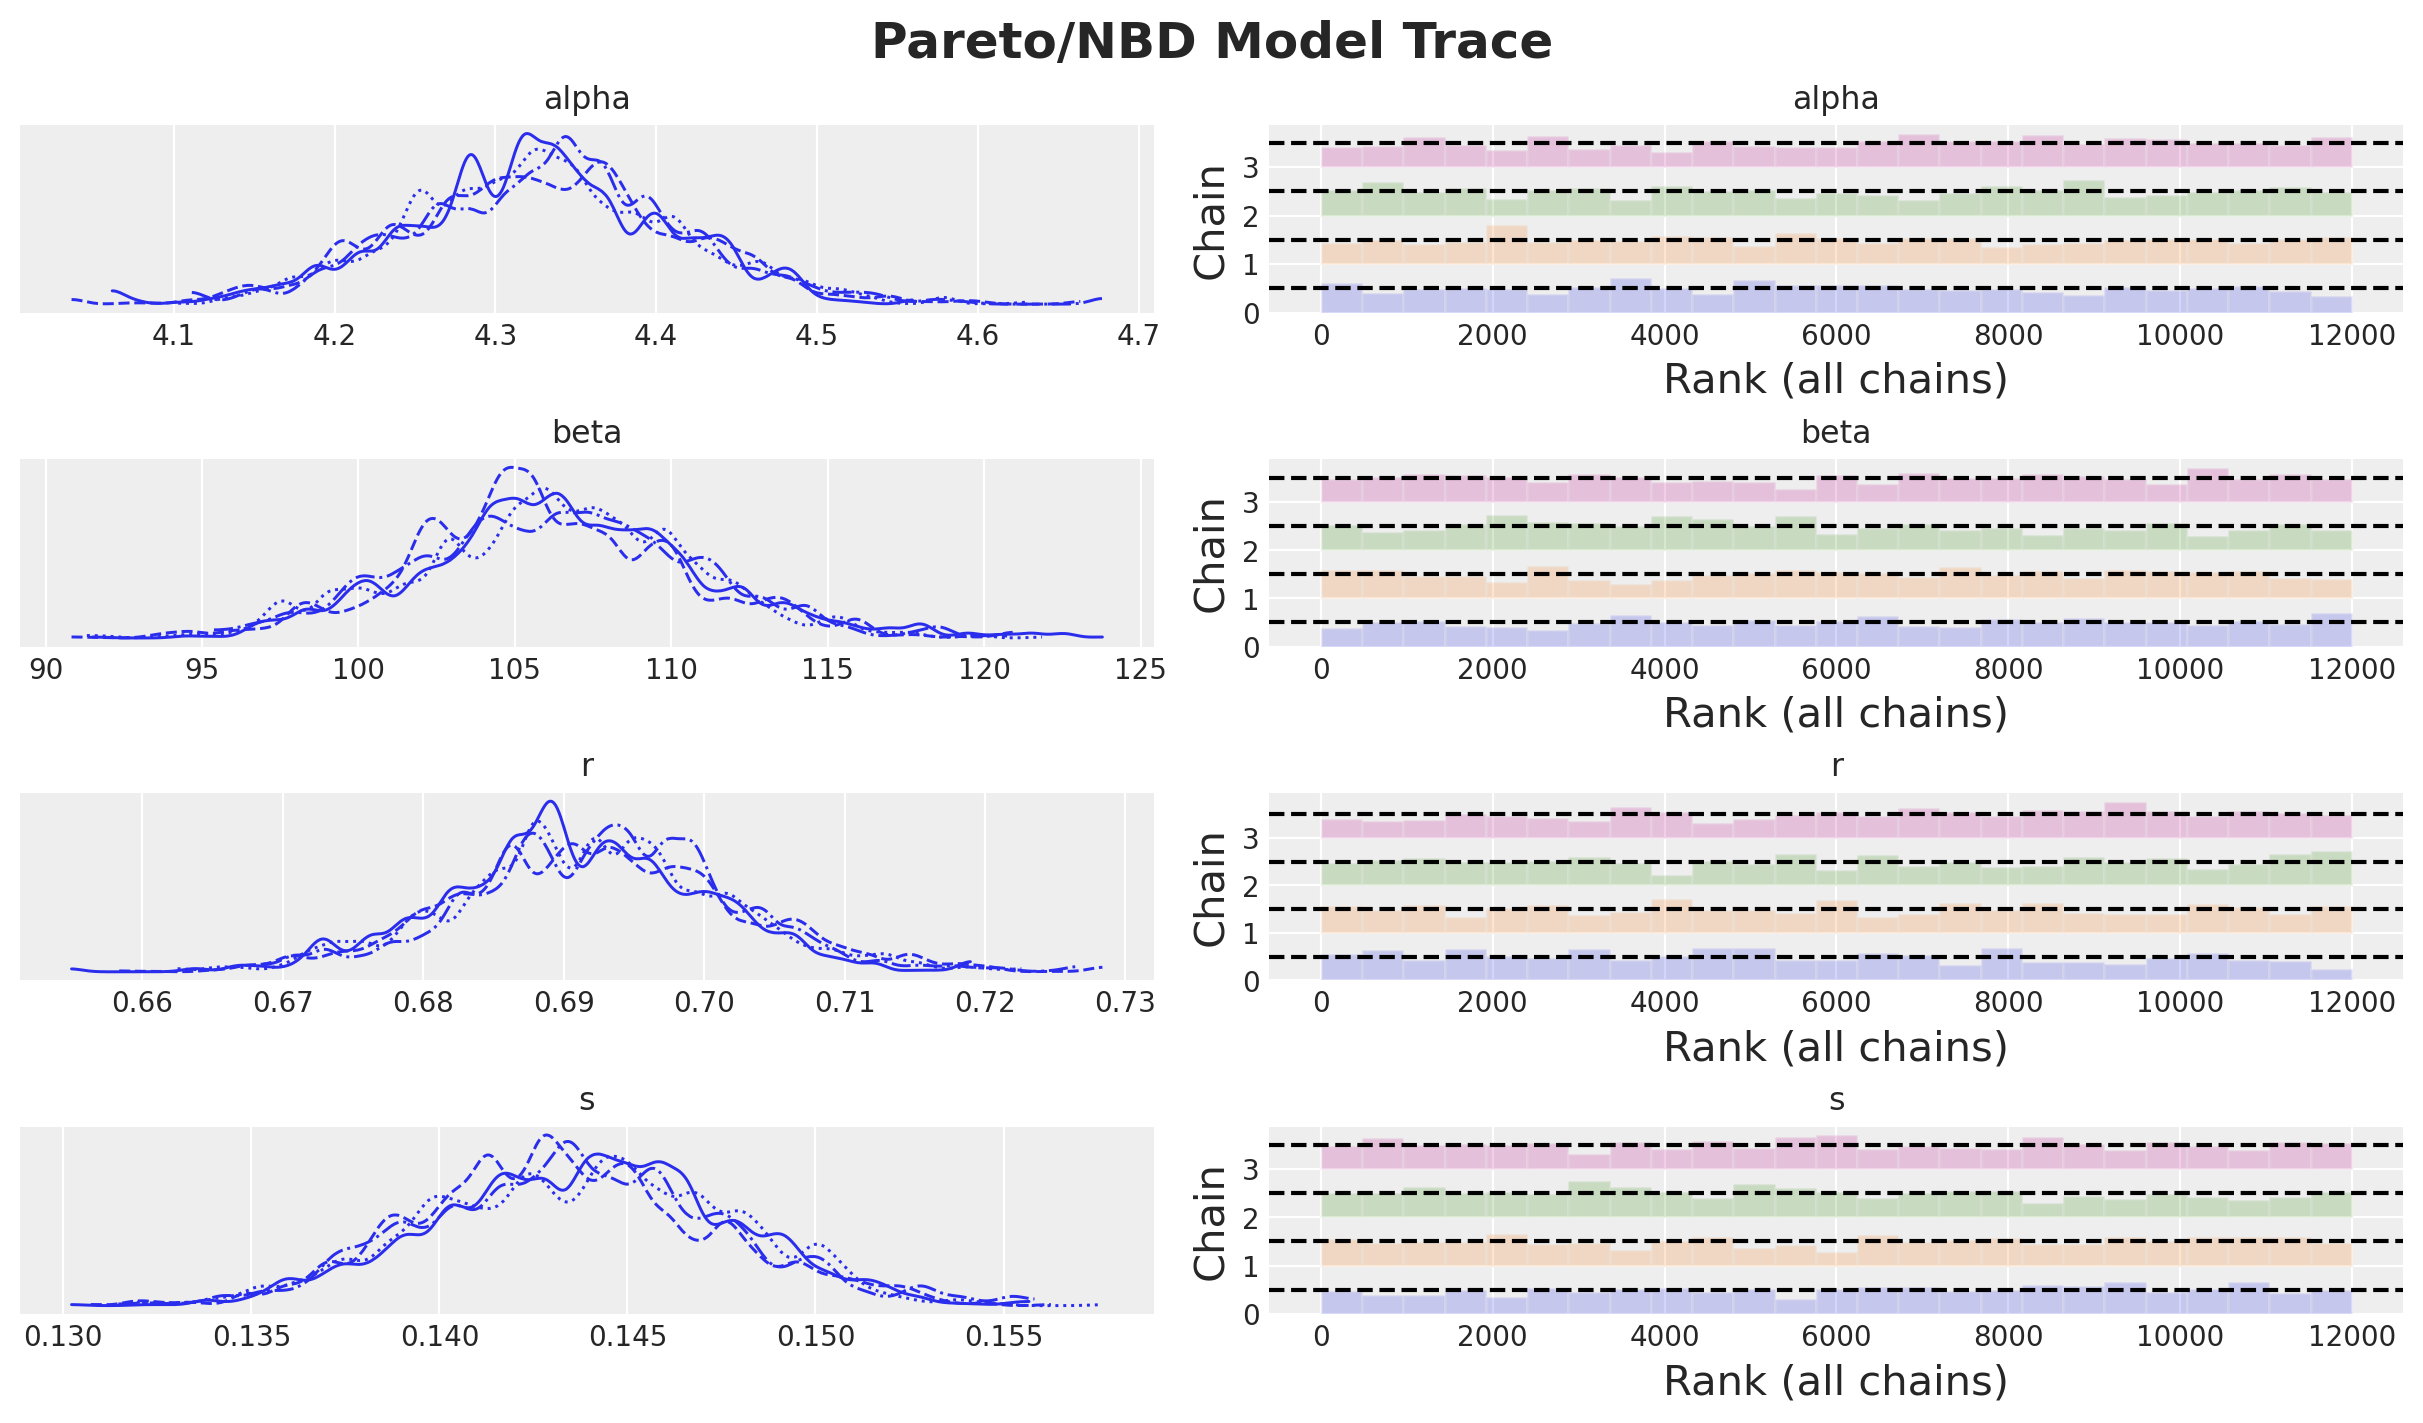

In [22]:
axes = az.plot_trace(
    data=pnbd_full.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Pareto/NBD Model Trace", fontsize=18, fontweight="bold");

In [24]:
pnbd_full.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

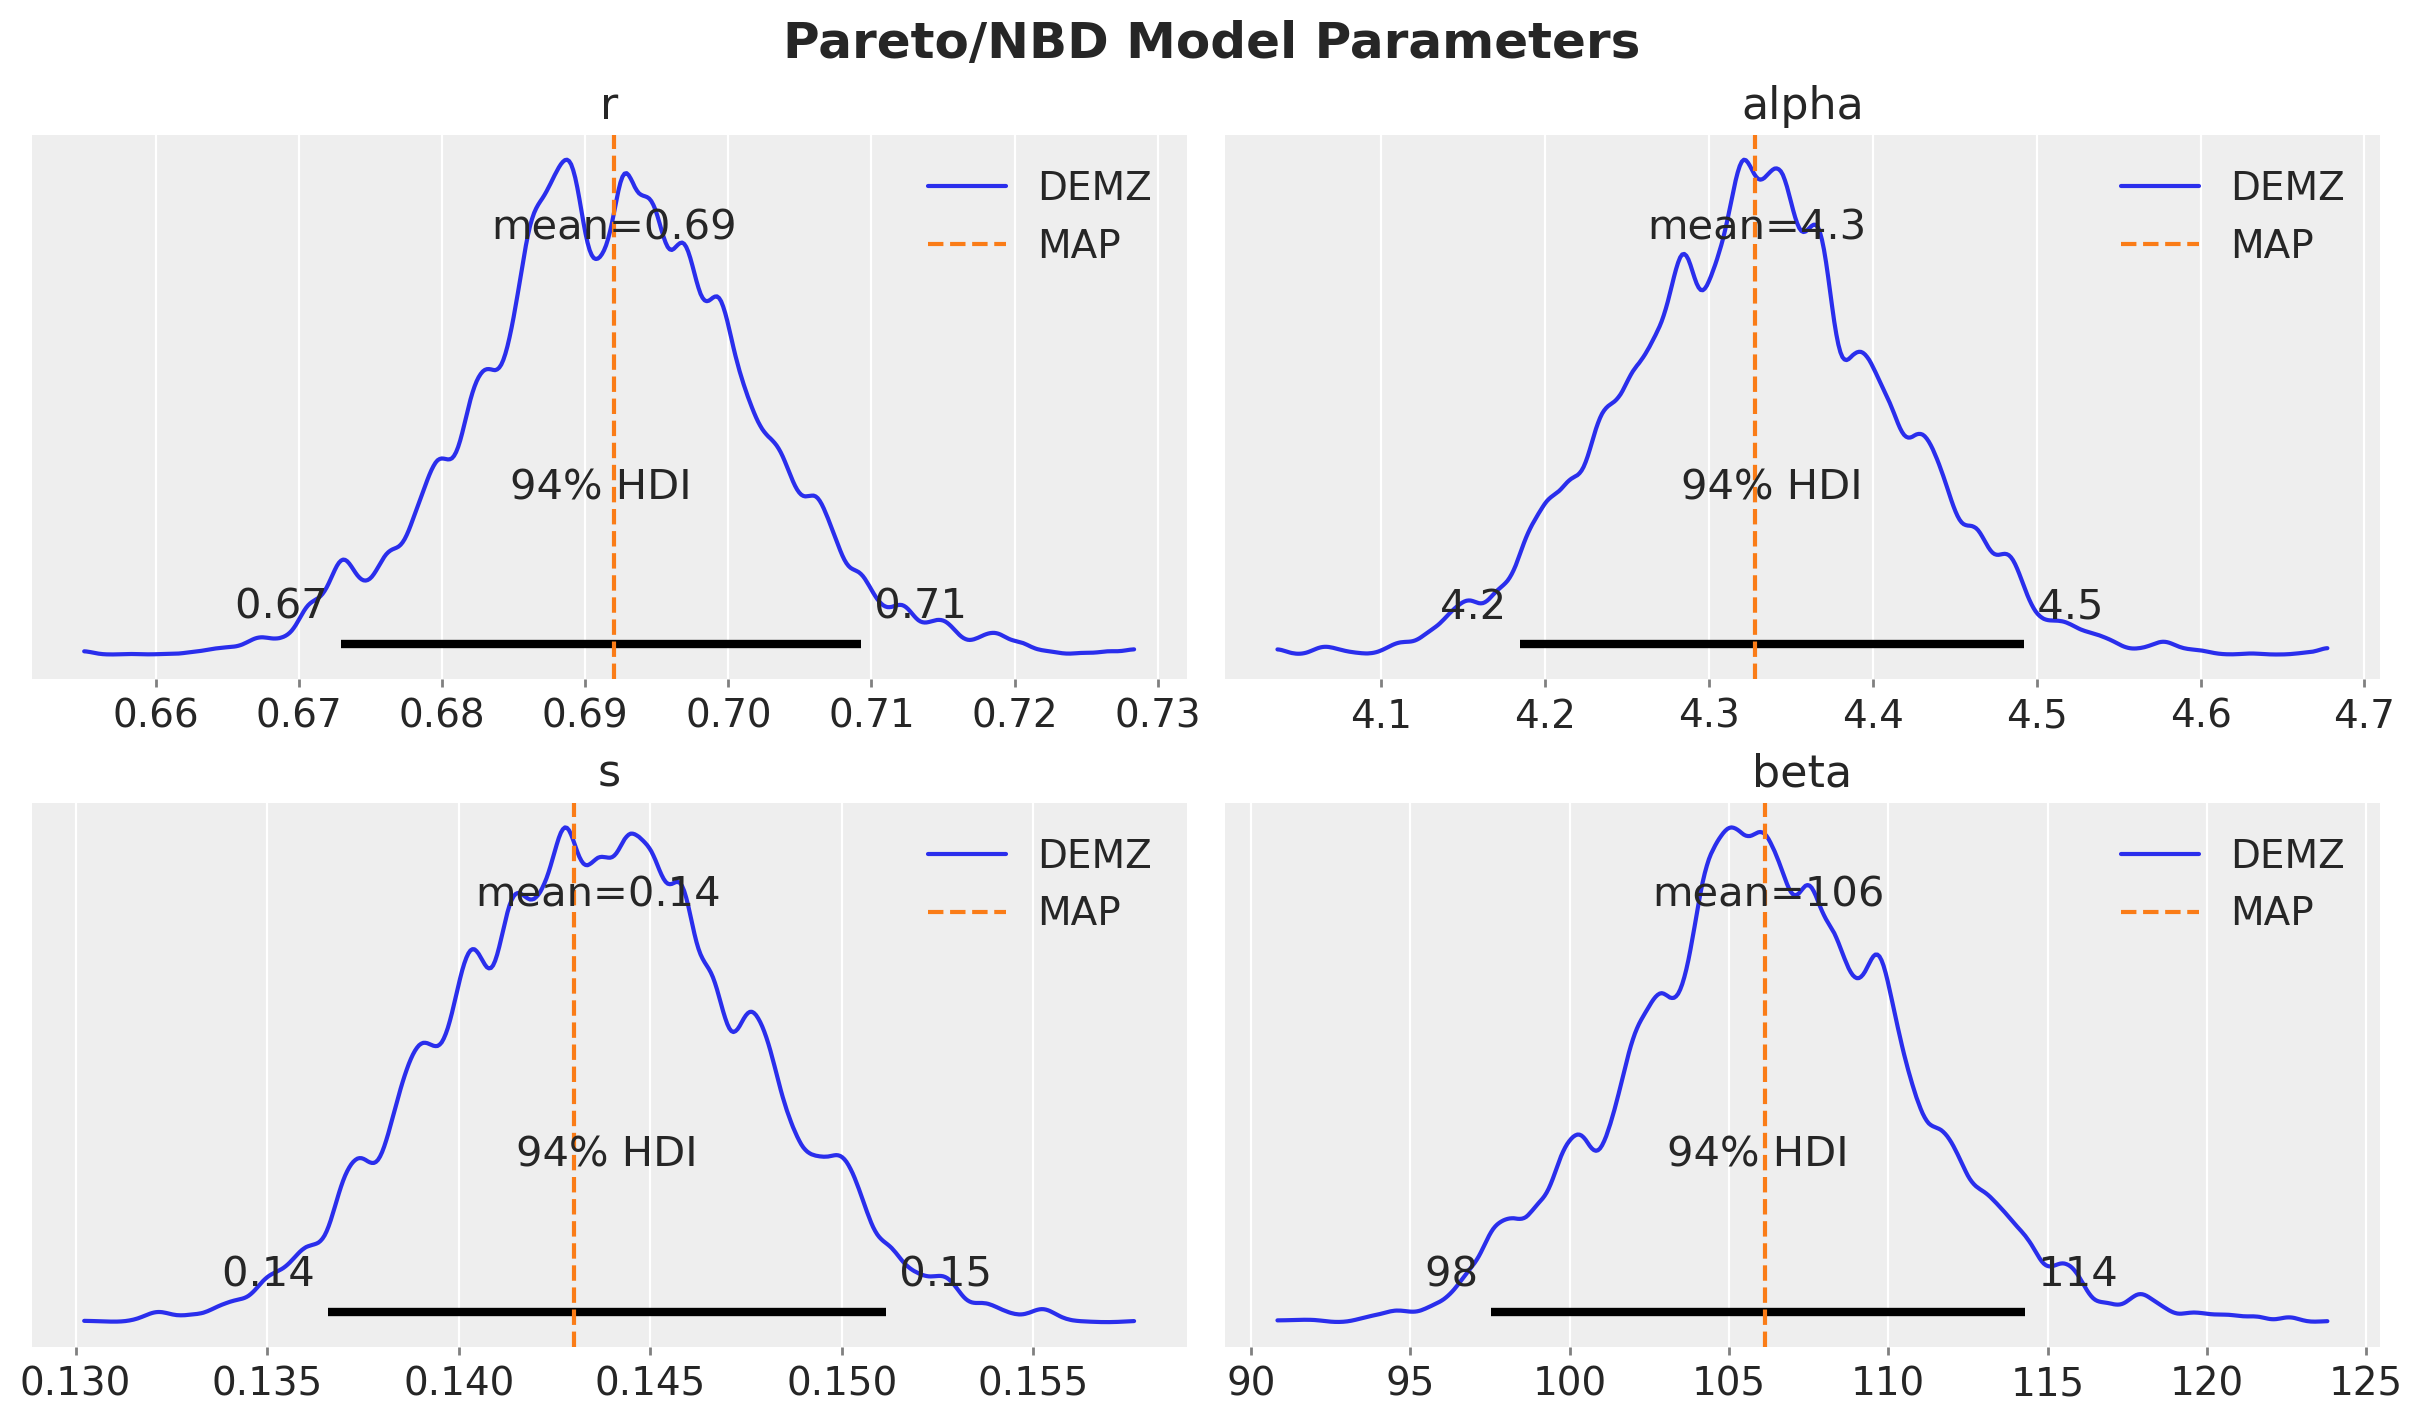

In [25]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    ax.axvline(x=map_fit[var_name], color="C1", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

In [26]:
example_customer_ids = [1364781544796422146, 33485, 35036, 33475, 4987, 5039]

data_small = data_summary_rfm.query("customer_id.isin(@example_customer_ids)")

data_small.sort_values(by="frequency")

,customer_id,frequency,recency,T,monetary_value
9,5039,4.0,630.0,1243.0,30.000000
7,4987,884.0,1683.0,1909.0,74.802036
639,33475,945.0,2098.0,2098.0,120.121693
722,35036,1060.0,1344.0,2059.0,427.688679
2967,1364781544796422146,1192.0,1376.0,1376.0,1693.431208
640,33485,1786.0,2093.0,2093.0,402.525196


In [27]:
time_periods = 90

expected_purchases_over_time = xr.concat(
    objs=[
        pnbd_full.expected_purchases(
            data=data_small,
            future_t=t,
        )
        for t in progress_bar(range(time_periods))
    ],
    dim="t",
).transpose(..., "t")

/Users/changyu/miniconda3/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


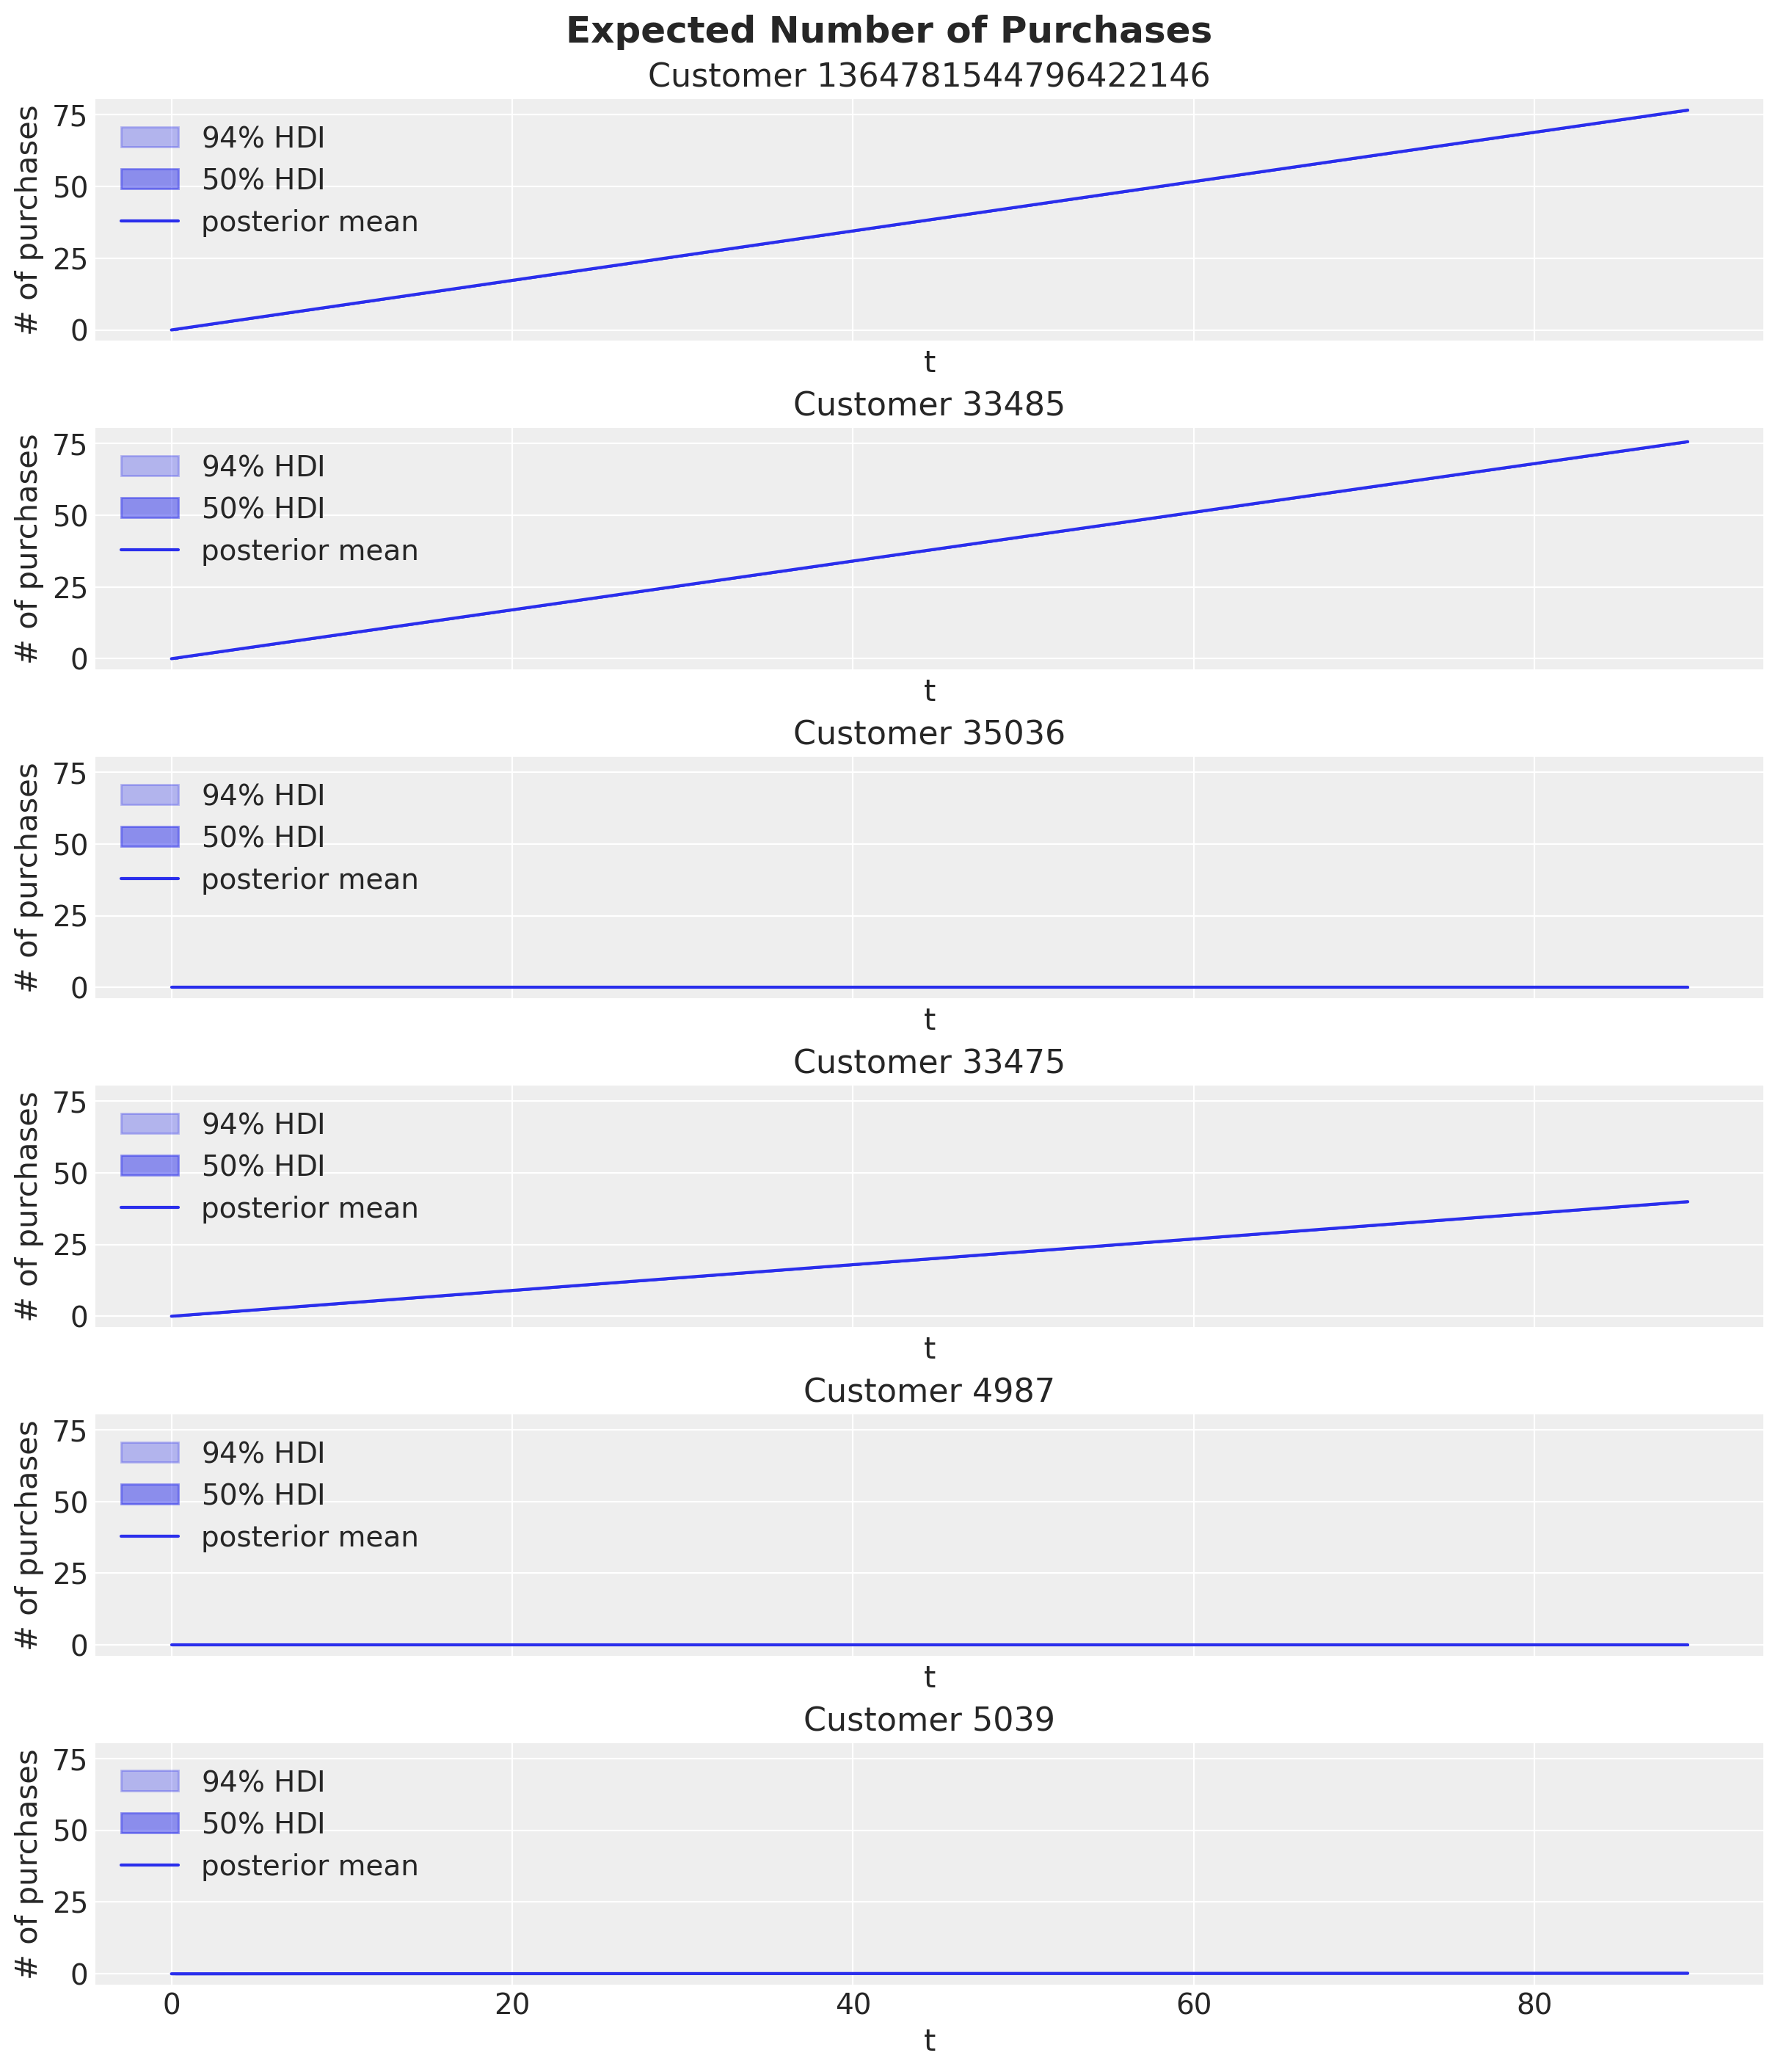

In [28]:
_, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 14),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_purchases = expected_purchases_over_time.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(time_periods),
        customer_expected_purchases.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="# of purchases")

axes[-1].set(xlabel="t")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

In [ ]:
_, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    demz_alive = pnbd_full.expected_probability_alive(
        data_small,
        future_t=0,
    ).sel(customer_id=customer_id)
    map_alive = pnbd_map.expected_probability_alive(data_small, future_t=0).sel(
        customer_id=customer_id
    )

    az.plot_density(demz_alive, hdi_prob=1, colors="C1", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=map_alive, color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set(
        title=f"Customer {customer_id}",
        xlabel="Probability Alive",
        ylabel="Posterior Density",
    )

plt.gcf().suptitle("Expected Probability Alive", fontsize=18, fontweight="bold");

In [ ]:
_, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    demz_alive = pnbd_full.expected_probability_alive(
        data_small,
        future_t=90,
    ).sel(customer_id=customer_id)
    map_alive = pnbd_map.expected_probability_alive(data_small, future_t=0).sel(
        customer_id=customer_id
    )

    az.plot_density(demz_alive, hdi_prob=1, colors="C1", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=map_alive, color="C3", linestyle="--", label="MAP at Time 0")
    ax.legend(loc="upper left")
    ax.set(
        title=f"Customer {customer_id}",
        xlabel="Probability Alive",
        ylabel="Posterior Density at Time 90",
    )

plt.gcf().suptitle("Expected Probability Alive Delta", fontsize=18, fontweight="bold");

In [ ]:
# create arrays of parameter combinations
n_purchases = np.repeat([0, 3, 6, 9, 12, 15], 6)
time_periods = np.tile([15, 30, 45, 60, 75, 90], 6)

expected_purchase_prob_heatmap = xr.concat(
    objs=[
        pnbd_map.expected_purchase_probability(
            data_small,
            n_purchases=params[0],
            future_t=params[1],
        ).sel(customer_id=46)
        for params in zip(n_purchases, time_periods, strict=False)
    ],
    dim="customer_id",
).transpose(..., "customer_id")

In [ ]:
heatmap_reshape = expected_purchase_prob_heatmap.values.reshape(6, 6)

sb.heatmap(heatmap_reshape, annot=True)

plt.xlabel("Time Periods")
plt.xticks(np.arange(6) + 0.5, [15, 30, 45, 60, 75, 90], rotation=0)
plt.ylabel("Number of Purchases")
plt.yticks(np.arange(6) + 0.5, [0, 3, 6, 9, 12, 15], rotation=0)
plt.gcf().suptitle(
    "Expected Purchase Probabilities for Customer 46", fontsize=18, fontweight="bold"
);